# Computational Interaction Final Assignment

## 1. 환경 설정

In [1]:
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch

print(f"Python Version: {sys.version}")
print(f"Current Working Directory: {os.getcwd()}")

# Add current directory to path to ensure src is importable
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from src.simulator.drift_diffusion import DriftDiffusionSimulator
    from src.fitting.ami import (
        DriftDiffusionTrainingDataset,
        DriftDiffusionValidationDataset,
        DriftDiffusionAmortizedInferenceTrainer,
        DriftDiffusionInferenceEngine
    )
    print("Imports successful!")
except ImportError as e:
    print(f"Import failed: {e}")
    print(f"sys.path: {sys.path}")
    raise e

%matplotlib inline
%load_ext autoreload
%autoreload 2

Python Version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.0.13.3)]
Current Working Directory: /Users/woochul/workplace/wcjung/yonsei/drift-diffusion-amortizer_assignment
Imports successful!


## 2. Drift Diffusion Simulation

### Amortized Inference Engine 학습을 위한 데이터 생성

- Drift-diffusion 모델 파라미터(drift rate(a), boundary separation(µ), non-decision time(Ter))를 1000개 샘플링
- 각 파라미터당 32개의 행동 데이터를 추출하여 학습 데이터셋을 구축
- 파라미터 샘플링 범위: a ~ U(0.045, 0.18), µ ~ U(0, 0.5), Ter ~ U(0.05, 0.4)

생성된 학습(tr_*.npz) 및 검증(vd_*.npz) 데이터셋은 아래 폴더에 저장
- 경로: data/amortizer/dataset/<CONFIGURATION_HASH>/
- <CONFIGURATION_HASH>는 설정(config)에 따라 생성된 고유 ID 폴더
- 해당 폴더 내에 tr_...npz (학습용)와 vd_...npz (검증용) 파일이 생성

Parameters used for simulation: {'a': 0.15582112281160465, 'mu': 0.32027283072162627, 'T_er': 0.2809089152961177, 'eta': 0.1067, 's_z': 0.0321, 's_t': 0.0943, 'sigma': 0.1, 'step_size': 5e-05, 'a_z_ratio': 2.0}
Reaction time: 0.6932596617879989, Correct: 1


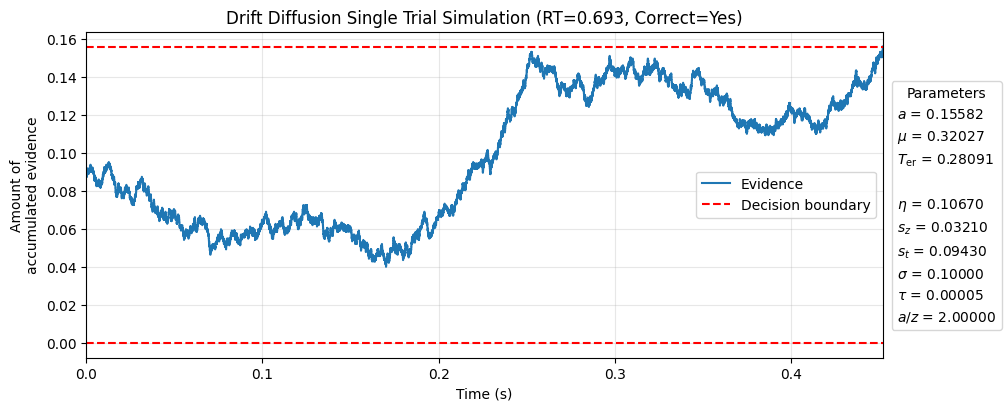

In [2]:
# Initialize Simulator
simulator = DriftDiffusionSimulator(config='default')

# Visualize a single simulation trace
simulator.visualize_single_simulation(save_image=False, verbose=True)

Drift Diffusion Simulation: 100%|██████████| 1000/1000 [00:02<00:00, 433.88it/s]


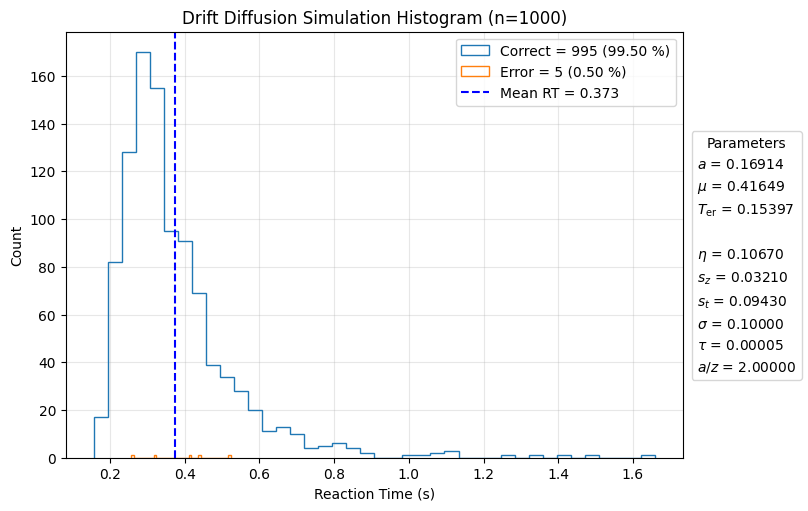

In [3]:
# Visualize Reaction Time Histogram
simulator.visualize_simulation_histogram(num_of_simul=1000, verbose=True)

In [4]:
# Configuration for training
simul_config = 'default'
data_config = 'default'
train_config = 'default'
model_name = 'ddm_amortizer_v1'

In [5]:
# Generate Training Data (if not exists)
print("Checking/Generating Training Data...")
train_dataset = DriftDiffusionTrainingDataset(
    simul_config=simul_config,
    data_config=data_config,
    loading_existing_data=False
)

if not glob.glob(os.path.join(train_dataset.data_path, "tr_*.npz")):
    print("Generating new training data...")
    # Note: This might take some time. Adjust n_param_per_file and repeat for faster testing.
    train_dataset.generate_new_data(n_param_per_file=1024, repeat=2, n_jobs=4)
else:
    print("Training data already exists.")

Checking/Generating Training Data...
Training data already exists.


## 3. [Subtask 1] Amortized Inference Training

구축된 학습 데이터셋을 이용하여 추론 엔진(Amortized Inference Engine)을 학습

- **목표**: 신경망을 활용해 파라미터와 행동 데이터 간의 관계를 학습
- **결과물**: 학습된 모델 체크포인트 파일 (`.pt`) -> **과제 제출 파일**
- **저장 위치**: `data/amortizer/models/<model_name>/pts/`

In [6]:
# Generate Validation Data
print("Checking/Generating Validation Data...")
val_dataset = DriftDiffusionValidationDataset(
    simul_config=simul_config,
    data_config=data_config,
    loading_existing_data=False
)

if not glob.glob(os.path.join(val_dataset.data_path, "vd_*.npz")):
    print("Generating new validation data...")
    val_dataset.generate_new_data(n_param=100, n_jobs=4)
else:
    print("Validation data already exists.")

Checking/Generating Validation Data...
Validation data already exists.


In [7]:
# Initialize Trainer (now that data exists)
trainer = DriftDiffusionAmortizedInferenceTrainer(
    name=model_name,
    simul_config=simul_config,
    data_config=data_config,
    train_config=train_config
)

# Train the model
trainer.train(
    n_iter=20,          # Adjust iterations as needed
    step_per_iter=100, 
    batch_sz=64,
    save_freq=5
)

print(f"\n[Subtask 1 Complete] Model Checkpoint saved at: {trainer.model_path}")
print(f"Please submit the .pt file found in this directory.")

Loading training data: 100%|██████████| 1/1 [00:00<00:00, 488.73it/s]


Loaded existing data from 1 file(s) - total parameters: 64, total trials: 2048 (per parameter: 32)


Loading validation data: 100%|██████████| 1/1 [00:00<00:00, 1290.56it/s]


Loaded existing data from 1 file(s) - total parameters: 20, total trials: 640 (per parameter: 32)

[ Training - ddm_amortizer_v1 ]


 Iter 5: 100%|██████████| 100/100 [00:02<00:00, 48.23it/s, Avg.Loss: 0.065]


- parameter recovery (simulated) - Avg. R2=(0.83)


 Iter 10: 100%|██████████| 100/100 [00:01<00:00, 50.04it/s, Avg.Loss: 0.058]


- parameter recovery (simulated) - Avg. R2=(0.83)


 Iter 15: 100%|██████████| 100/100 [00:01<00:00, 50.35it/s, Avg.Loss: 0.050]


- parameter recovery (simulated) - Avg. R2=(0.83)


 Iter 20: 100%|██████████| 100/100 [00:02<00:00, 49.98it/s, Avg.Loss: 0.049]


- parameter recovery (simulated) - Avg. R2=(0.84)

[ Training Done ]
  Training Loss: 0.048889006040990356



## 4. [Subtask 2] Parameter Inference and Evaluation

학습된 모델을 검증 데이터셋(100개 파라미터)에 적용하여 성능을 평가합니다.
- Parameter Recovery Plot (R2) 확인

In [8]:
# Initialize Inference Engine with the trained model
engine = DriftDiffusionInferenceEngine(model_name=model_name)

# Perform validation and plot parameter recovery
valid_res, r_squared = trainer.valid(verbose=True)

[ inference engine - loaded model ] ddm_amortizer_v1 - Iteration 20
- parameter recovery (simulated) - Avg. R2=(0.84)


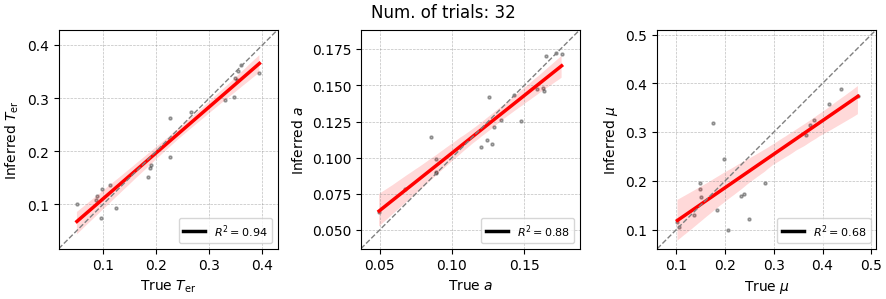

In [9]:
# Display the recovery plot
from IPython.display import Image

# Find the latest recovery plot
recovery_plots = glob.glob(f"{trainer.result_path}/iter*/recovery.png")
if recovery_plots:
    latest_plot = sorted(recovery_plots)[-1]
    display(Image(filename=latest_plot))
else:
    print("No recovery plot found.")

## 5. [Subtask 3] Real User Parameter Inference

실제 유저 데이터(`data/behavior/user_data_sample.csv`)를 로드하여 각 유저의 파라미터를 추론합니다.

- **결과물**: 추론된 파라미터가 담긴 CSV 파일 (`real_user_inference_results.csv`)

In [ ]:
import pandas as pd

# 1. Load Real User Data
user_data_path = 'data/behavior/user_data_sample.csv'
real_user_df = pd.read_csv(user_data_path)

print(f"Loaded real user data: {len(real_user_df)} trials")
print(real_user_df.head())

# 2. Infer Parameters for Each User
user_ids = real_user_df['user_id'].unique()
inferred_results = []

print(f"\nStart Inference for {len(user_ids)} users...")

features = engine.data_config.feature

for uid in user_ids:
    # Extract user data
    user_trials = real_user_df[real_user_df['user_id'] == uid]
    
    # Prepare input
    # If features are simply ['reaction_time', 'correct'], we select them.
    try:
        user_stat_data = user_trials[features].to_numpy()
    except KeyError:
        # Fallback mapping if keys don't match
        # Common mapping: rt -> reaction_time
        rename_map = {'reaction_time': 'rt', 'correct': 'response'}
        # user_trials has ['user_id', 'reaction_time', 'correct']
        pass # rely on user to fix if names completely mismatch, but print warning?
        # Let's assume 'features' list matches CSV or simulation used these names.
        user_stat_data = user_trials[['reaction_time', 'correct']].to_numpy()

    _, params = engine.infer(user_stat_data, return_samples=False)
    
    # Store result
    res = {'user_id': uid}
    res.update(params)
    inferred_results.append(res)

# 3. Convert to DataFrame
inferred_df = pd.DataFrame(inferred_results)
print("\nInferred Parameters Summary:")
print(inferred_df.describe())
print("\nFirst 5 Users:")
print(inferred_df.head())

# 4. Save Results
save_path = 'real_user_inference_results.csv'
inferred_df.to_csv(save_path, index=False)
print(f"\nInferred results saved to {save_path}")


Loaded real user data: 3142 trials
   user_id  reaction_time  correct
0        0       0.205200        1
1        0       0.195190        1
2        0       0.170166        1
3        0       0.160156        1
4        0       0.165161        1

Start Inference for 40 users...

Inferred Parameters Summary:
         user_id       T_er          a         mu
count  40.000000  40.000000  40.000000  40.000000
mean   19.500000   0.179150   0.087915   0.349994
std    11.690452   0.046944   0.021018   0.085576
min     0.000000   0.077770   0.052466   0.179914
25%     9.750000   0.147108   0.071029   0.271804
50%    19.500000   0.179938   0.084614   0.355414
75%    29.250000   0.219775   0.102661   0.417321
max    39.000000   0.251080   0.138810   0.500000

First 5 Users:
   user_id      T_er         a        mu
0        0  0.077770  0.074092  0.179914
1        1  0.126336  0.066256  0.272645
2        2  0.166787  0.072194  0.267203
3        3  0.173881  0.079951  0.184505
4        4  0.239548 